In [55]:
import sys

import networkx as nx
import igraph as ig
from networkx.generators.community import LFR_benchmark_graph

import numpy as np
import time

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 3

#sys.path.append("/home/oriol/Documents/Trento/JacobianGeometry/Code/Dynamics_v2/")
sys.path.append("/Users/giacomobarzon/Desktop/Network_geometry/Code_8thJune/Dynamics_v2/")
#sys.path.append("/home/barzon/Network_geometry/Code_8thJune/Dynamics_v2/")

import CommonFunctions as cf
import plotter

import importlib
importlib.reload(cf)
importlib.reload(plotter)

<module 'plotter' from '/Users/giacomobarzon/Desktop/Network_geometry/Code_8thJune/Dynamics_v2/plotter.py'>

In [49]:
N = 60
mean_deg = 8

num_groups = 4; nodes_per_group = N//num_groups; kave = mean_deg; k_out = .15#kave is local average
k_in = kave - k_out
p_in = k_in/nodes_per_group
p_out = k_out/(nodes_per_group*num_groups - nodes_per_group)
print('Block model probs: in %f - out %f' % (p_in, p_out))

G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

while nx.is_connected(G_gn) == 0:
    print('The network should be in a single component. New trial!')
    G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

infoG_gn = ['GN',k_out]

print('Mean degree', np.mean(list(dict(G_gn.degree()).values())))

Block model probs: in 0.523333 - out 0.003333
The network should be in a single component. New trial!
Mean degree 7.666666666666667


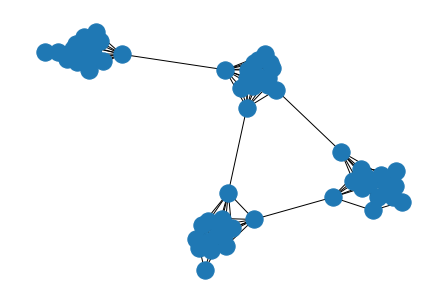

In [50]:
nx.draw(G_gn)

In [56]:
def Simu(G, infoG):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    #num_time_points = 50 # small to decrease computational load
    times = np.linspace(0, num_nodes, num = num_nodes+1) #time to find the steady state    
    times_perturbation = np.linspace(0, num_nodes, num = num_nodes+1) #times at which we look how the perturbation evolves
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    
    dist_t = []
    avg_dist_t = []
    eigvals = []
    
    for dynamics in cf.dynamics_list:
        
        if dynamics == 'Diffusion':
            ### DIFFUSION
            print('[*] DIFFUSION DISTANCE')
            print('Evaluating diffusion distance...')
            tmp_d = cf.Laplacian(nx.to_numpy_array(G), times_perturbation, return_snapshot=True, norm=True)
        
        else:
            ### JACOBIAN
            print('[*] JACOBIAN DISTANCE - '+str(dynamics))
        
            #Integration to get the steady state
            print('Integration up to steady state...')
            initial_state = np.random.random(len(G.nodes()))   
            SteadyState_ref, char_time = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
            SteadyState_ref = SteadyState_ref[-1]

            # analytical expression of Jacobian
            print('Evaluating jacobian distance...')
            tmp_d = cf.Jacobian(G, dynamics, SteadyState_ref, times_perturbation, return_snapshot=True, norm=True)
        
        dist_t.append(tmp_d[0])
        avg_dist_t.append(tmp_d[1])
        eigvals.append(tmp_d[2])
        
    return dist_t, avg_dist_t, eigvals, times_perturbation

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic
Integration up to steady state...


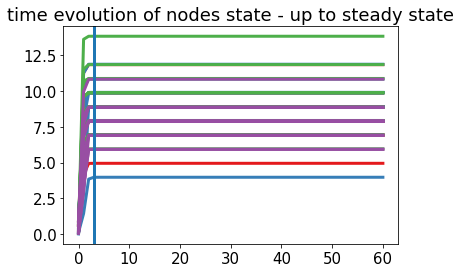

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Biochemical
Integration up to steady state...


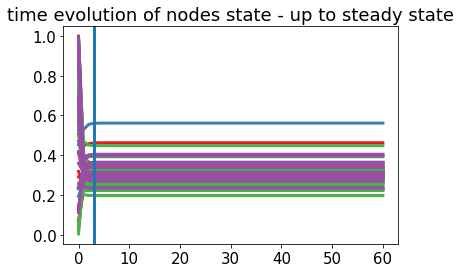

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Population
Integration up to steady state...


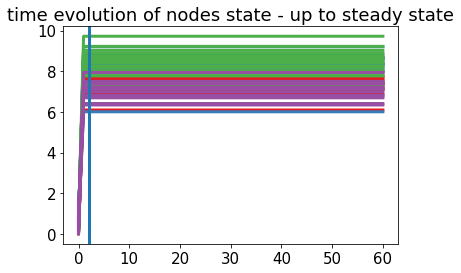

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Regulatory
Integration up to steady state...


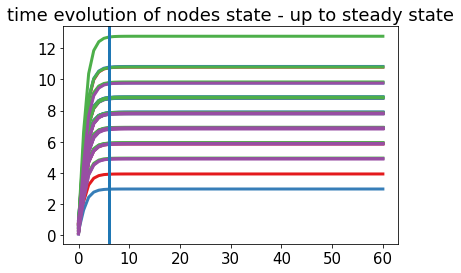

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Epidemics
Integration up to steady state...


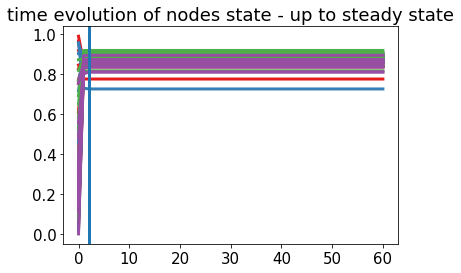

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Synchronization
Integration up to steady state...


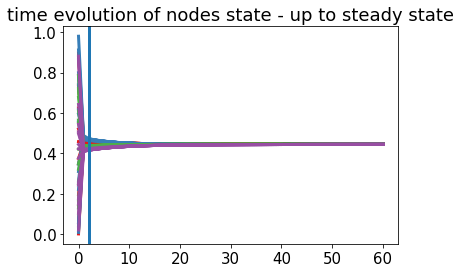

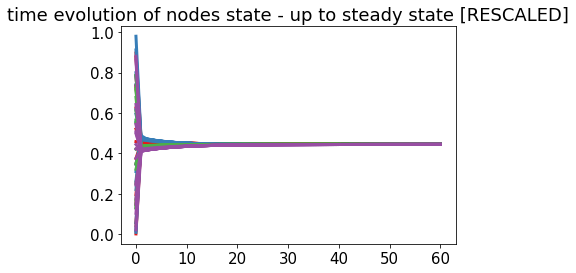

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Neuronal
Integration up to steady state...


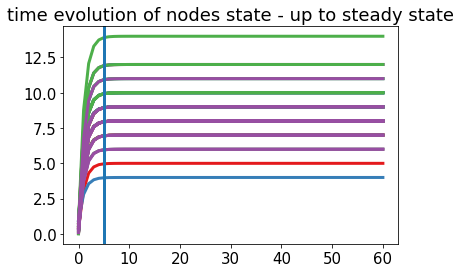

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - NoisyVM
Integration up to steady state...


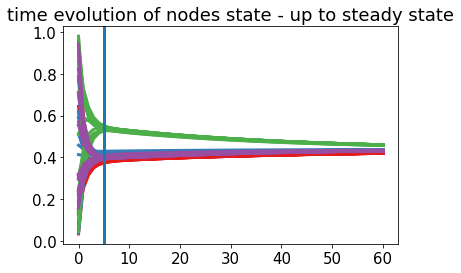

Evaluating jacobian distance...



[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


In [57]:
dist_t, avg_dist_t, eigvals, times = Simu(G_gn, infoG_gn)

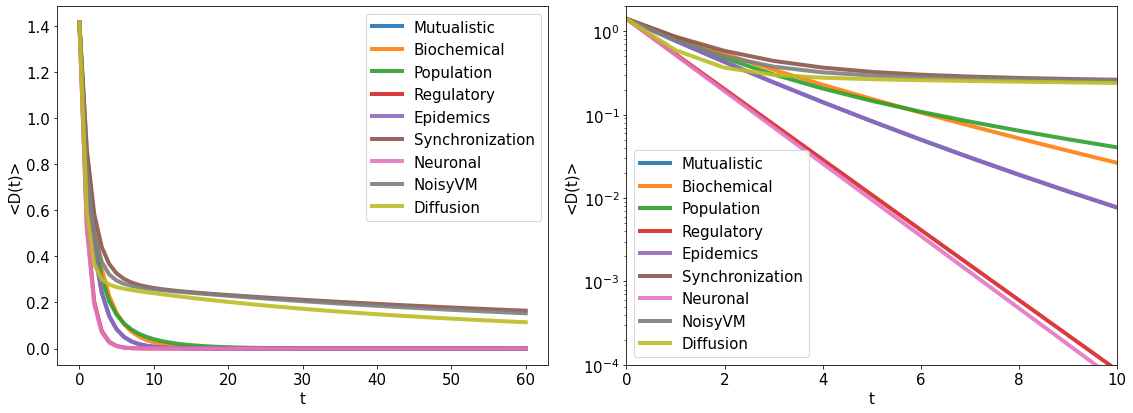

In [58]:
plt.figure(figsize=(16,6))

lw = 4.

plt.subplot(1,2,1)

for i, res in enumerate(dist_t):
    plt.plot(res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)

plt.xlabel('t')
plt.ylabel('<D(t)>')
#plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)

for i, res in enumerate(dist_t):
    plt.plot(res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)

plt.ylim([1e-4, 2])
plt.xlim([0, 10])
plt.xlabel('t')
plt.ylabel('<D(t)>')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

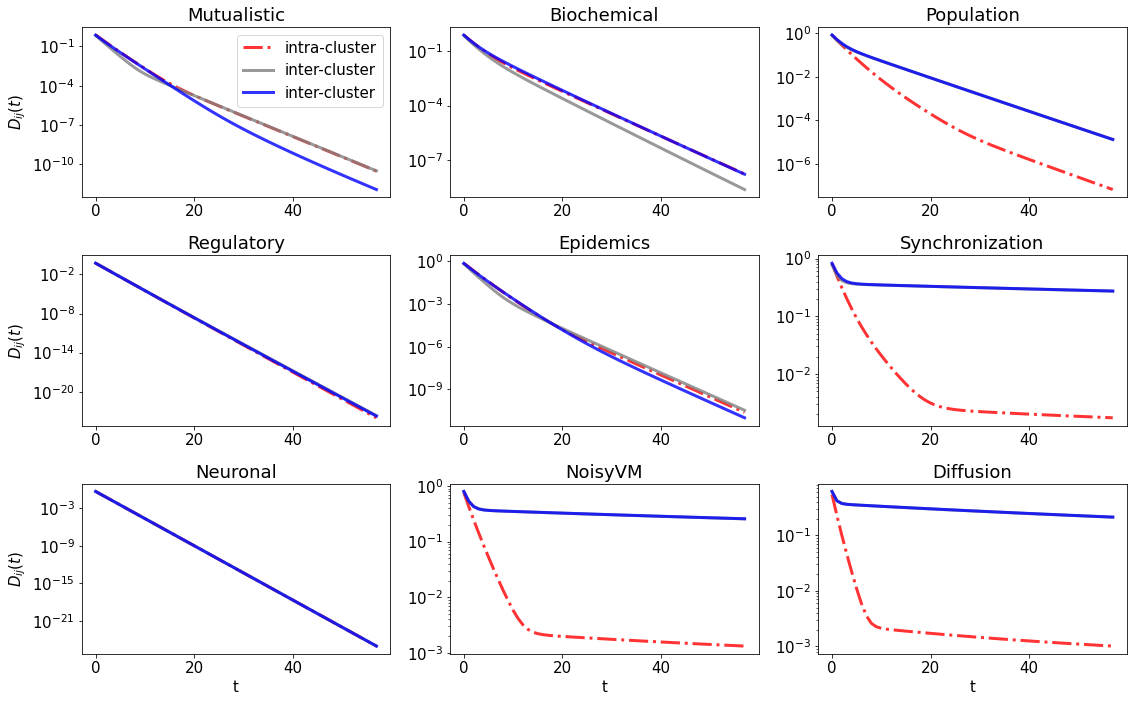

In [59]:
node_a = 0
node_b = 1
node_c = N-2
node_d = N-1

Tmax = N-1
alpha = 0.8

plt.figure(figsize=(16,10))

for i, res in enumerate(avg_dist_t):
    plt.subplot(3, 3, i+1)

    plt.plot(res[1:Tmax,node_a,node_b], '-.', label='intra-cluster', c='red', alpha=alpha)
    #plt.plot(res[1:Tmax,node_c,node_d], '-.', label='intra-cluster', c='black', alpha=alpha)
    plt.plot(res[1:Tmax,node_a,node_c], label='inter-cluster', c='gray', alpha=alpha)
    plt.plot(res[1:Tmax,node_b,node_c], label='inter-cluster', c='blue', alpha=alpha)

    plt.yscale('log')

    if i%3==0:
        plt.ylabel(r'$D_{ij}(t)$')
    if i-5>0:
        plt.xlabel('t')
    
    plt.title(cf.dynamics_list[i])
    
    if i==0:
        plt.legend()

plt.tight_layout()
plt.show()

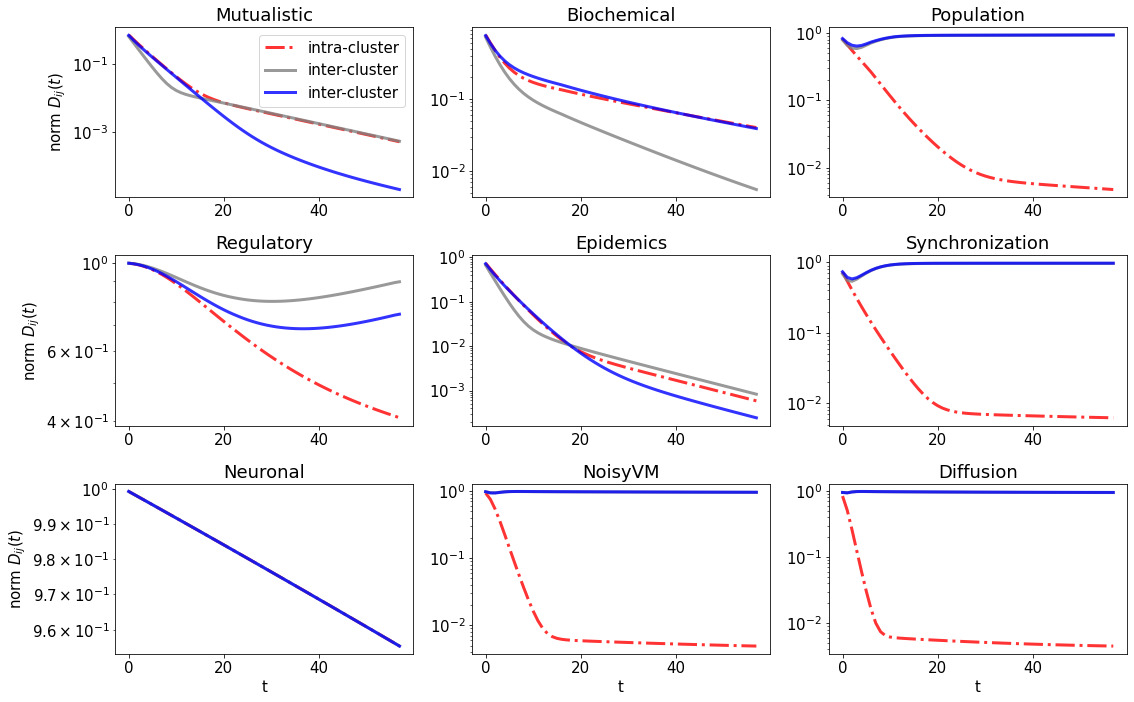

In [60]:
node_a = 0
node_b = 1
node_c = N-2
node_d = N-1

Tmax = N-1
alpha = 0.8

plt.figure(figsize=(16,10))

for i, res in enumerate(avg_dist_t):
    plt.subplot(3, 3, i+1)

    plt.plot(res[1:Tmax,node_a,node_b] / np.max(res[1:Tmax],axis=2).max(axis=1), '-.', label='intra-cluster', c='red', alpha=alpha)
    #plt.plot(res[1:Tmax,node_c,node_d], '-.', label='intra-cluster', c='black', alpha=alpha)
    plt.plot(res[1:Tmax,node_a,node_c] / np.max(res[1:Tmax],axis=2).max(axis=1), label='inter-cluster', c='gray', alpha=alpha)
    plt.plot(res[1:Tmax,node_b,node_c] / np.max(res[1:Tmax],axis=2).max(axis=1), label='inter-cluster', c='blue', alpha=alpha)

    plt.yscale('log')

    if i%3==0:
        plt.ylabel(r'norm $D_{ij}(t)$')
    if i-5>0:
        plt.xlabel('t')
    
    plt.title(cf.dynamics_list[i])
    
    if i==0:
        plt.legend()

plt.tight_layout()
plt.show()

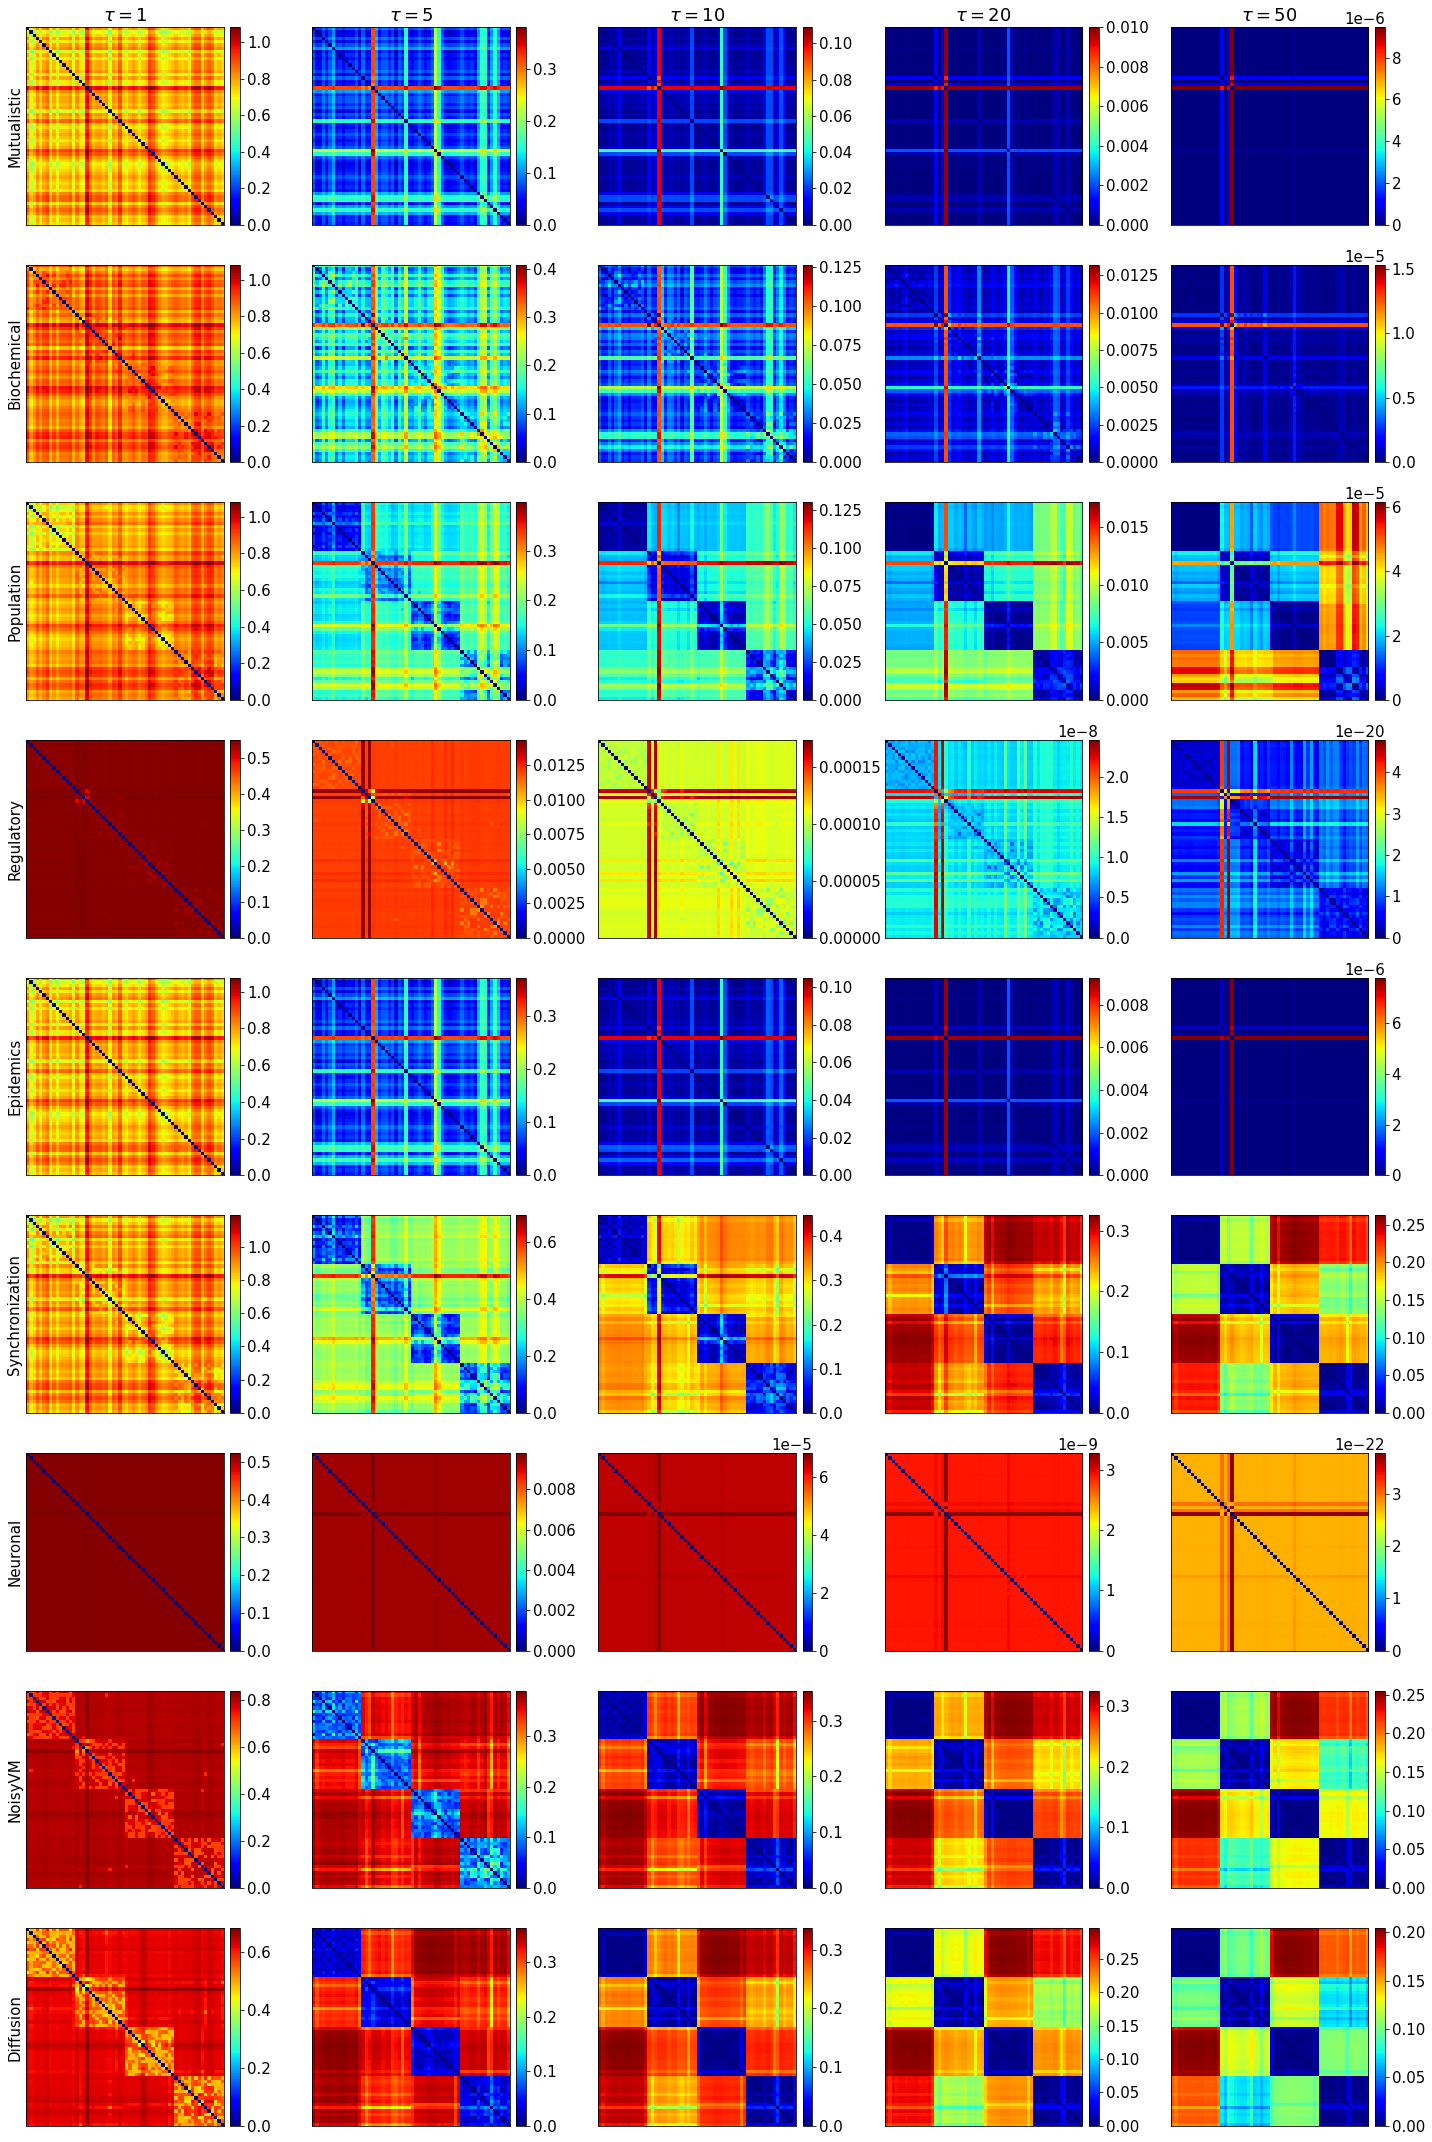

In [45]:
plotter.plot_dist_matrix_evol(avg_dist_t, cf.dynamics_list, hspace=0)

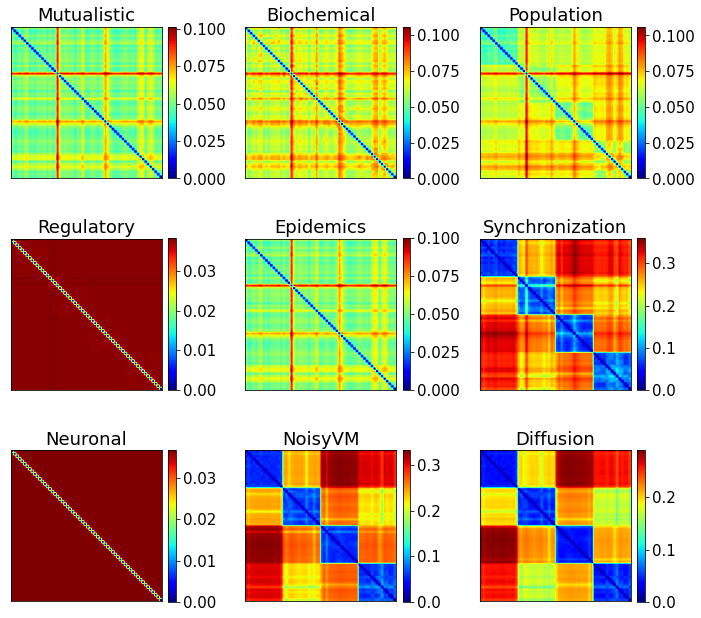

In [46]:
plotter.plot_average_dist_matrix(avg_dist_t, cf.dynamics_list, hspace=-.95)

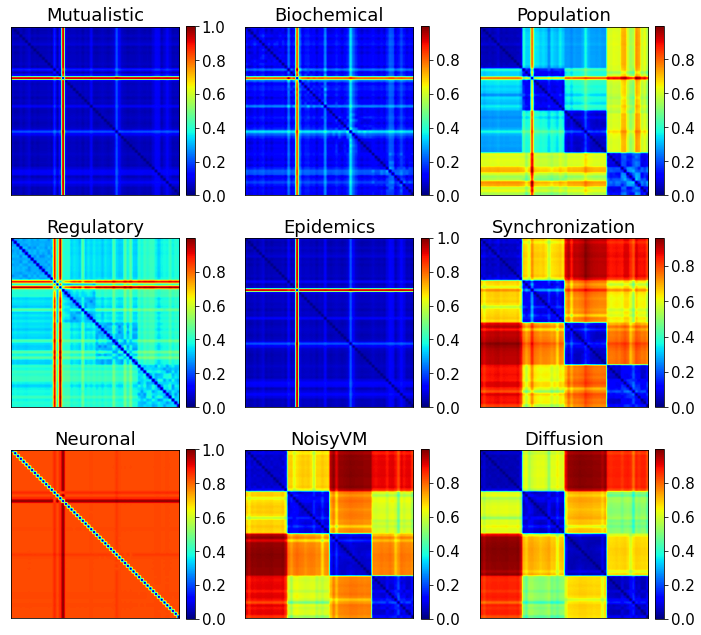

In [47]:
plotter.plot_average_dist_matrix(avg_dist_t, cf.dynamics_list, hspace=-.95, norm = True)